### Import the libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tempfile
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# build LSTMs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, BatchNormalization, Input, MaxPooling1D, Conv1D, TimeDistributed
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# use tensorflow 
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# mount the Google Drive to Google Colab
from google.colab import drive
drive.mount("/content/drive", force_remount=False)

%cd "/content/drive/My Drive/"

Found GPU at: /device:GPU:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/sensors2020


### Load data

In [3]:
f = open('accgry_segments.pckl', 'rb')
segments = pickle.load(f)
f.close()

f = open('accgry_labels.pckl', 'rb')
labels = pickle.load(f)
f.close()

In [4]:
# config based on data preprocessing
sampling_freq = 100
window_size = int(5.12*sampling_freq)
overlap = 1*sampling_freq # 1s overlap
feature_size = 18
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments),window_size, feature_size)

### Split data

In [9]:
train_x, test_x, train_y, test_y = train_test_split(reshaped_segments, labels, test_size=0.1, random_state=1)
print(train_x.shape, test_x.shape)

(15571, 512, 18) (1731, 512, 18)


### Build the LSTM

In [12]:
def get_lstm(train_x, train_y, test_x, test_y):
    
    # define model
    n_hidden = 100
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    model = Sequential()
    model.add(LSTM(n_hidden, return_sequences=True, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(LSTM(n_hidden))
    model.add(Dense(n_hidden, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics = ["categorical_accuracy"], optimizer=Adam())

    # return the model
    return model

### Train the simple LSTM on the Training set

In [16]:
# build LSTM
model = get_lstm(train_x, train_y, test_x, test_y)

# setup network
verbose, epochs, batch_size = 2, 15, 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# fit network
lstm_history = model.fit(train_x, train_y, epochs=epochs, validation_split=.1,
                    batch_size=batch_size, verbose=verbose, callbacks=[callback])
# evaluate model
_, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
print(model.summary())
print("Accuracy", accuracy)

Epoch 1/15
219/219 - 13s - loss: 0.7671 - categorical_accuracy: 0.7767 - val_loss: 0.5298 - val_categorical_accuracy: 0.8408
Epoch 2/15
219/219 - 10s - loss: 0.3661 - categorical_accuracy: 0.8904 - val_loss: 0.3166 - val_categorical_accuracy: 0.9166
Epoch 3/15
219/219 - 10s - loss: 0.2645 - categorical_accuracy: 0.9229 - val_loss: 0.3521 - val_categorical_accuracy: 0.9012
Epoch 4/15
219/219 - 10s - loss: 0.2959 - categorical_accuracy: 0.9136 - val_loss: 0.3962 - val_categorical_accuracy: 0.8716
Epoch 5/15
219/219 - 10s - loss: 0.2483 - categorical_accuracy: 0.9263 - val_loss: 0.2745 - val_categorical_accuracy: 0.9198
Epoch 6/15
219/219 - 10s - loss: 0.1753 - categorical_accuracy: 0.9475 - val_loss: 0.2002 - val_categorical_accuracy: 0.9461
Epoch 7/15
219/219 - 10s - loss: 0.1246 - categorical_accuracy: 0.9628 - val_loss: 0.1078 - val_categorical_accuracy: 0.9660
Epoch 8/15
219/219 - 10s - loss: 0.1056 - categorical_accuracy: 0.9676 - val_loss: 0.4370 - val_categorical_accuracy: 0.8556


### Plot LSTM results

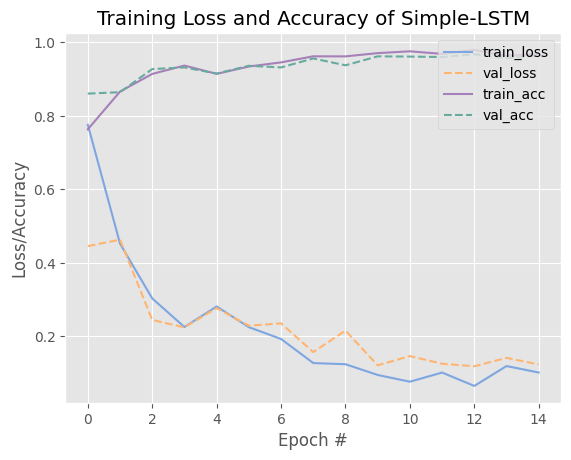

In [ ]:
plt.show()
plt.style.use('ggplot')
plt.grid(True)
plt.plot(lstm_history['loss'],'#7EA6E0')
plt.plot(lstm_history['val_loss'],color = '#FFB570', linestyle='dashed')
plt.plot(lstm_history['categorical_accuracy'],'#A680B8')
plt.plot(lstm_history['val_categorical_accuracy'], color = '#67AB9F', linestyle='dashed')
plt.title('Training Loss and Accuracy of Simple-LSTM')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(['train_loss', 'val_loss', 'train_acc', 'val_acc'], loc='upper right')
plt.show()

### Build the CNN-LSTM

In [ ]:
def get_cnnlstm(train_x, train_y, test_x, test_y):
    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 4, 128
    train_x = train_x.reshape((train_x.shape[0], n_steps, n_length, n_features))
    test_x = test_x.reshape((test_x.shape[0], n_steps, n_length, n_features))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    # return the model
    return model

### Train the CNN-LSTM on the Training set

In [ ]:
# build CNN-LSTM
model = get_cnnlstm(train_x, train_y, test_x, test_y)

# setup network
verbose, epochs, batch_size = 2, 15, 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# fit network
lstmcnn_history = model.fit(train_x, train_y, epochs=epochs, validation_split=.1, batch_size=batch_size, verbose=verbose, callbacks=[callback])

# evaluate model
_, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
print(model.summary())
print("Accuracy", accuracy)

(15571, 4, 128, 18)
(1731, 4, 128, 18)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, None, 126, 64)     3520      
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, 124, 64)     12352     
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 124, 64)     0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, None, 62, 64)      0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 3968)        0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               1627600   
_________________________________________________________________
dropout_7 (Drop

### Plot CNN-LSTM results

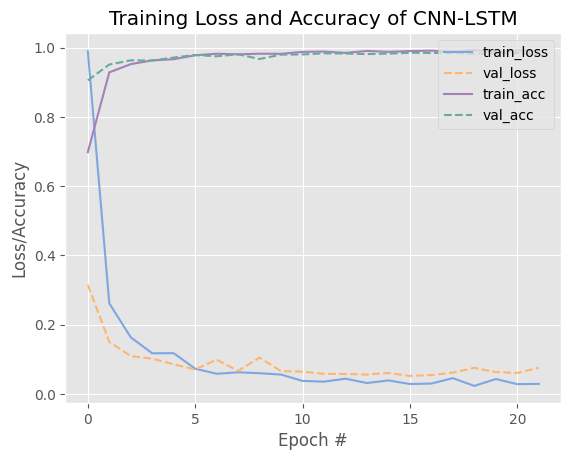

In [ ]:
plt.show()
plt.style.use('ggplot')
plt.grid(True)
plt.plot(lstmcnn_history_dict['loss'],'#7EA6E0')
plt.plot(lstmcnn_history_dict['val_loss'],color = '#FFB570', linestyle='dashed')
plt.plot(lstmcnn_history_dict['accuracy'],'#A680B8')
plt.plot(lstmcnn_history_dict['val_accuracy'], color = '#67AB9F', linestyle='dashed')
plt.title('Training Loss and Accuracy of CNN-LSTM')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(['train_loss', 'val_loss', 'train_acc', 'val_acc'], loc='upper right')
plt.show()